In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)
library(rwantshue)
library(RColorBrewer)

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked fro

In [3]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [4]:
%%R
physeq.pruned = physeq
sample_data(physeq.pruned)$Day = as.numeric(sample_data(physeq.pruned)$Day)
taxonomy <- data.frame(tax_table(physeq.pruned))
sampledata = data.frame(sample_data(physeq.pruned))
dseq = phyloseq_to_deseq2(physeq.pruned, ~Cosm+Day)
#dseq$Day = factor(dseq$Day)
#dseq$Day = relevel(dseq$Day,"0")
dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
results = results(dseq, cooksCutoff=TRUE)
results = data.frame(rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
colnames(results) = c("OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
head(results)

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  warnings.warn(x, RRuntimeWarning)


                          OTU   baseMean          l2FC          SE    pvalue
16SW83_1069699 16SW83_1069699 0.10844002 -0.0003733751 0.002917687 0.8981731
16SW15_380479   16SW15_380479 0.02599132 -0.0001057086 0.002917640 0.9710983
16SW73_374389   16SW73_374389 0.54937786 -0.0031284354 0.013827205 0.8210053
16SW87_1469358 16SW87_1469358 0.09805092 -0.0002056653 0.002917640 0.9438034
16SW13_1202991 16SW13_1202991 0.06916559  0.0001968112 0.002917640 0.9462190
16SW139_208607 16SW139_208607 3.48690661  0.0109953971 0.021079507 0.6019381
                Kingdom         Phylum               Class              Order
16SW83_1069699 Bacteria Proteobacteria Deltaproteobacteria Desulfovibrionales
16SW15_380479  Bacteria   Fusobacteria       Fusobacteriia    Fusobacteriales
16SW73_374389  Bacteria Planctomycetes                <NA>               <NA>
16SW87_1469358 Bacteria Planctomycetes                <NA>               <NA>
16SW13_1202991 Bacteria Proteobacteria Deltaproteobacteria             

In [5]:
%%R
DA = results
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}

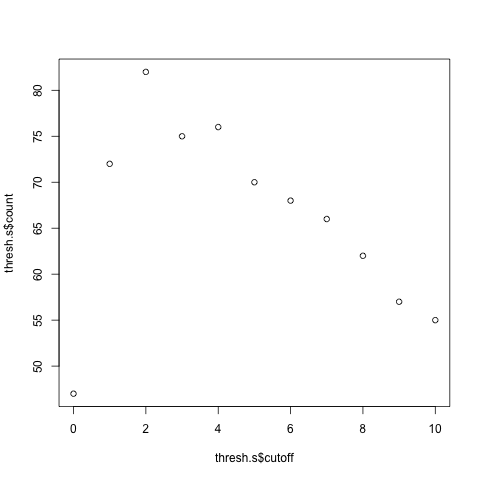

In [6]:
%%R
range = seq(0,10,1)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)

In [11]:
%%R
group_by(DA) %>%
    mutate(Total=sum(baseMean)) %>%
    filter(baseMean>=2) %>% 
    mutate(padj = p.adjust(pvalue,"BH")) %>% 
    write.csv("../../SeqData/l2fc.DayCosmControlNumeric.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [12]:
%%R
l2fc<-read.csv("../../SeqData/l2fc.DayCosmControlNumeric.csv")

In [15]:
%%R

cutoff = 1
FDR = 0.1

d = l2fc %>%
    mutate(Sig = ifelse(padj<FDR&l2FC>=cutoff,1,0))%>%
    mutate(Sig = ifelse(is.na(padj)==TRUE,0,Sig))%>%
    count(Sig)%>%
    mutate(Fraction=n/sum(n))
mean(d$Fraction[d$Sig==1])

[1] NaN


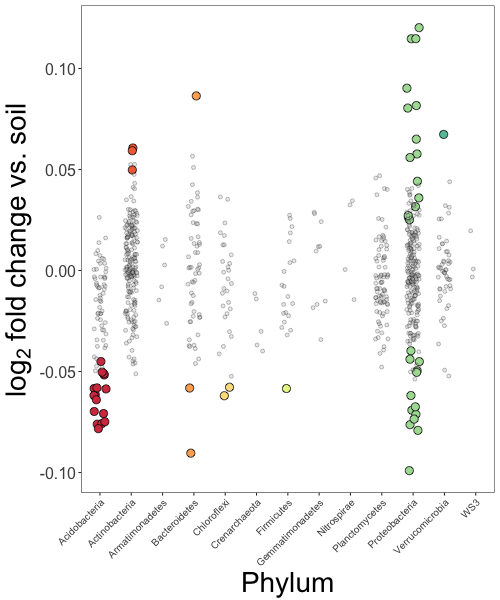

In [16]:
%%R -w 500 -h 600
# setting the image sizes, then making the figure...

d = l2fc
FDR = 0.1

d = d %>%
    #group_by(TrtmtDay) %>%
    mutate(sig = ifelse(padj<=FDR,1,0))%>%
    mutate(relabund=baseMean/Total)%>%
    filter(Family!="mitochondria")%>%
    filter(Class!="Chloroplast")%>%
    filter(pvalue != 'NA')
# This compares it to the whole sample, not just the signficantly increased subset in l2fc
    
max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values
    
p = ggplot(d, aes(x = Phylum, y = l2FC, fill = Phylum))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.


d$sig = as.factor(d$sig)
    
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
    
p = p + geom_point(data=d.yes, aes(x = Phylum, y = l2FC, fill = Phylum), shape = 21, size=3.5, alpha=1, position = position_jitter(w = 0.20))
p = p + geom_point(data=d.no, aes(x = Phylum, y = l2FC, fill = sig), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))

#p = p + geom_hline(y = 1, linetype=2)
#p = p + geom_hline(y = -1, linetype=2)
#p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 10, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Phylum")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.
    
colourCount = 8
getPalette = colorRampPalette(brewer.pal(8, "Spectral"))
p = p + scale_fill_manual(guide="none", values=c("grey",paste(getPalette(colourCount))))


#p = p + scale_color_continuous(trans="log")    
#p = p + scale_fill_discrete(guide="none")


p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

I think this approach is the best - which taxa continue to increase with duration of root exposure?

In [22]:
%%R
d = l2fc %>%
    mutate(pos=ifelse(l2FC>0,"positive","negative"))%>%
    mutate(Fract = baseMean/sum(baseMean))%>%
    group_by(pos,Phylum,Class,Order,Family, Genus, Species)%>%
    filter(padj<0.1)%>%
    summarize(n=n(),SumFract=sum(Fract))%>%
    filter(n>0)%>%
    arrange(pos,Phylum,Class,Order,Family,-n)


In [23]:
%%R
data.frame(d)

        pos           Phylum                Class                Order
1  negative    Acidobacteria [Chloracidobacteria]                 RB41
2  negative    Acidobacteria      Acidobacteria-6              iii1-15
3  negative    Acidobacteria       Acidobacteriia     Acidobacteriales
4  negative    Acidobacteria       Acidobacteriia     Acidobacteriales
5  negative    Acidobacteria       Acidobacteriia     Acidobacteriales
6  negative    Acidobacteria       Acidobacteriia     Acidobacteriales
7  negative    Acidobacteria               iii1-8                DS-18
8  negative    Bacteroidetes        [Saprospirae]      [Saprospirales]
9  negative    Bacteroidetes           Cytophagia         Cytophagales
10 negative    Bacteroidetes     Sphingobacteriia   Sphingobacteriales
11 negative      Chloroflexi         Anaerolineae              SBR1031
12 negative      Chloroflexi                 TK10                 <NA>
13 negative       Firmicutes              Bacilli           Bacillales
14 neg

In [19]:
%%R
write.csv(d,"../../SeqData/l2fc.DayControlNumeric.RespondersSummary.csv", row.names=FALSE)

Sphingomonas wittichii is associated with complex C degradation.